Pick N representative samples from an 1-D array based on their value

# Start

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def detect_gaps(a_unique: np.array) -> bool:
    '''heuristic to avoid empty bins'''
    bin_width = (a_unique.max() - a_unique.min()) / (n - 1)
    gap_detected = False
    dist = 0
    for i in range(len(a_unique)-1):
        prev_dist = dist
        dist = a_unique[i+1] - a_unique[i]
        if dist + prev_dist > 2 * bin_width:
            gap_detected = True
    return gap_detected

In [4]:
def prepare_array(arr: np.array, n: int):
    a_unique = np.unique(arr)
    if len(a_unique) < n:
        err_msg = f'N={n} is higher than the number of unique values.'
        raise ValueError(err_msg)
    return a_unique

In [5]:
def prepare_bins(a_unique: np.array, n: int) -> tuple:
    min_ = a_unique.min()
    max_ = a_unique.max()
    a_linspace = np.linspace(
        min_,
        max_,
        n * 2 - 1
    )
    bin_borders = a_linspace[1::2]
    bin_borders = np.concatenate([[min_], bin_borders, [max_]])
    bin_centers = a_linspace[::2]
    bins = {}
    for i in range(len(bin_borders)-1):
        bins[i] = {
            'left': bin_borders[i],
            'right': bin_borders[i+1],
            'center': bin_centers[i],
            'values': []
        }
    return bins, bin_borders, bin_centers

In [6]:
def plot(a_unique: np.array, bin_borders: np.array, bin_centers: np.array):
    plt.figure(figsize=(10, 1))
    #unique values
    plt.scatter(
        x=a_unique,
        y=np.ones_like(a_unique),
        c='gray'
    )
    #bin borders
    plt.scatter(
        x=bin_borders[1:-1],
        y=np.ones_like(bin_borders[1:-1]),
        marker='|',
        s=2000,
        c='orange'
    )
    # bin centers
    plt.scatter(
        x=bin_centers,
        y=np.ones_like(bin_centers),
        marker='x',
        s=20,
        c='red'
    )
    plt.yticks([])
    plt.show()
    return None

In [7]:
def split_into_bins(bins: dict, a_unique: np.array) -> dict:    
    n_bins = len(bins)
    current_bin = 0
    for val in a_unique:
        val_is_in_bin = False
        # print(f'{val=}', f'{current_bin=}')
        if val < bins[current_bin]['left']:
            continue
        while not val_is_in_bin:
            # print(f'{current_bin=}', bins[current_bin]['left'], bins[current_bin]['right'])
            val_is_in_bin = bins[current_bin]['left'] <= val
            val_is_in_bin &= bins[current_bin]['right'] > val
            if not val_is_in_bin:
                current_bin += 1
            if current_bin >= n_bins:
                break
        if current_bin >= n_bins:
            break
        else:
            bins[current_bin]['values'].append(val)
    bins[current_bin - 1]['values'].append(a_unique[-1])
    return bins

In [12]:
def prepare_bins_n_observations(a_unique, n, show_plot=False) -> dict:
    okay = False
    n_adjusted = n
    count = 0
    while not okay:
        count += 1
        bins, bin_borders, bin_centers = prepare_bins(a_unique, n_adjusted)
        # plot(a_unique, bin_borders, bin_centers)
        bins = split_into_bins(bins, a_unique)
        count_nonempty_bins = np.sum([1 for bin in bins.values() if bin['values']])
        if count_nonempty_bins < n:
            n_adjusted += 1
        else:
            okay = True
        if count == len(a_unique):
            break
    if show_plot:
        plot(a_unique, bin_borders, bin_centers)
    return bins

In [13]:
def get_selection_sequence(bins: dict) -> np.array:
    selection_sequence = []
    for bin in bins.values():
        bin_len = len(bin['values'])
        if bin_len:
            if bin_len == 1:
                selection_sequence.append([1])
            else:
                central_value_idx = 0
                val_0 = bin['values'][central_value_idx]
                min_dist_center = np.abs(val_0 - bin['center'])      
                for bin_val_idx in range(1, bin_len):
                    val = bin['values'][bin_val_idx]
                    dist_center = np.abs(val - bin['center'])
                    # print(f"{val=} center={bin['center']} {dist_center=} left={bin['left']} right={bin['right']}")
                    if dist_center < min_dist_center:
                        min_dist_center = dist_center
                        central_value_idx = bin_val_idx
                bin_map = np.zeros(bin_len)
                bin_map[central_value_idx] = 1
                selection_sequence.append(bin_map)
    selection_sequence = np.concatenate(selection_sequence)
    return selection_sequence



# Showcase

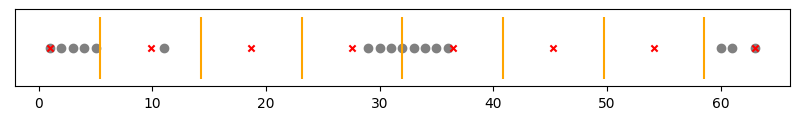

In [17]:
N = 8
a = np.array([1, 2, 3, 3, 3, 4, 5, 11, 29, 30, 30, 31, 32, 33, 34, 35, 36, 60, 60, 61, 63])
# a = np.array([1, 2, 3, 3, 3, 4, 5, 11, 29, 30, 30, 31])
# a = np.array([1, 2, 3, 3, 3, 4, 5, 11])


a_unique = prepare_array(a, N)
bins, bin_borders, bin_centers = prepare_bins(a_unique, N)
plot(a_unique, bin_borders, bin_centers)

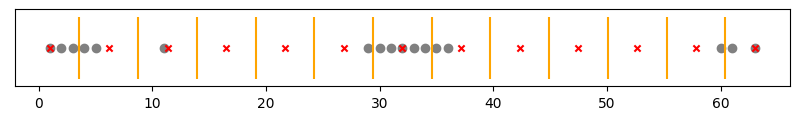

In [18]:
bins = prepare_bins_n_observations(a_unique, N, show_plot=True)

In [20]:
get_selection_sequence(bins)

array([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.])

# End